In [1]:
import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido, attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

base_path = ".." # Replace this with the path you want CROBAR putting files.
path.append(os.path.join(base_path,'python_modules'))
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

data_path = os.path.join(base_path,'example_data')
hmi_data_dir = data_path
aia_data_dir = data_path
crobar_output_dir = os.path.join(base_path,'save')
plot_dir = os.path.join(base_path,'plot')
rotation_directory = os.path.join(plot_dir,'rotation')

plt.rcParams.update({'font.size': 18,'figure.figsize':[10,6],'image.origin':'lower'})

In [2]:
length_unit = u.cm
date='2018/02/03 14:10:17'
datestr = date.replace('/','').replace(' ','_').replace(':','')

# Voxel size for CROBAR (0.42 Mm here)
dvox = np.array([(0.42*u.Mm).to(length_unit).value]*3)

# Voxel size for initial points:
flt_dvox = dvox*[1.0,1.0,10.0] # Initial point filtering voxel size
nloops_vol = 150 # Number of initial point randomly selected in the volume
nloops_flux = 4500 # Number of flux weighted initial points

# Value of force-free alpha to use for field line tracing:
alpha = 18.0/1.0e11   ############
alphastr = str(round(alpha/1.0e-11,3))

psf_size_px = 0.7 # Default PSF size in pixels
min_height = 1.0*dvox[2] # Loops must rise at least this high
min_length = 8.0*np.mean(dvox) # Loops must be at least this long

# Start tracing this high above the solar surface:
ivp_z0 = 0.02*dvox[2]
ivp_xpo = 1.0
ivp_clip = 0.99

download = False # Download from VSO
newpoints = 0 # Generate new seed points
newtrace = 0 # Retrace field lines

# Save footpoints to this file
footpoint_savefile = os.path.join(crobar_output_dir,'footpoints_'+datestr+'.pickle')
# Save traced loops to this file:
loop_savefile = os.path.join(crobar_output_dir,'loops_'+datestr+'_'+alphastr+'.pickle')
# Save emission cube to this file:
em3d_savefile = os.path.join(crobar_output_dir,'em3d_'+datestr+'_'+alphastr+'.npy')

# X and y range of solar images to use for SDO/STEREO:
[x0, y0, xsz0, ysz0] = [-110, -200, 250, 300]
[xl, yl, xh, yh] = [x0, y0, x0+xsz0, y0+ysz0]

# Voxels are padded inward from the crop range by this much:
vox_boundpad = np.array([[0.05,0.05,0.001],[-0.05,-0.05,-0.1]])
# Initial points are padded inward from the crop range by this much:
ivp_boundpad = np.array([[0.05,0.05,0.075],[-0.05,-0.05,-0.7]])

scaltemp1 = 0.7e6 # Temperature for estimating scale height of loop profile 1
scaltemp2 = 0.7e6 # Temperature for estimating scale height of loop profile 2
chan1_xpo = 2.0 # Assumed exponential power law index of the temperature response function
zmin0 = 2.63e8 # Minimum height

psfmat=None # reset this variable for later...

In [3]:
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
nloops0 = nloops_vol+nloops_flux
flux_factor = dvox[0]*dvox[1]
gfac = 1.0/2.2
length_unit = u.cm

# Massaging the x and y ranges:
# This is the nominal crop region
cropr0 = [x0, x0+xsz0, y0, y0+ysz0]*u.arcsec

# This is the crop region padded outward slightly,
# which provides the full dimensions of the reconstruction cube:
cropr = [x0-xsz0*(vox_boundpad[0,0]/(1-vox_boundpad[0,0])),x0+xsz0/(1+vox_boundpad[1,0]),
        y0-ysz0*(vox_boundpad[0,1]/(1-vox_boundpad[0,1])),y0+ysz0/(1+vox_boundpad[1,1])]*u.arcsec

# Crop the data for the reconstruction inward a bit compared to the cube. 
# This improves the ability of the reconstruction to fit the data, although 
# it does also mean that the edges of the reconstruction cube are underconstrained. 
cropr1 = cropr0+np.array([10,-10,10,-10])*u.arcsec

In [4]:
if(download):
	time_range = TimeRange(TimeRange(date,-10*u.s).start,TimeRange(date,10*u.s).end)
	qry_aia211 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(211*u.angstrom))
	aia211dat_path = Fido.fetch(qry_aia211[0][0],path=aia_data_dir)[0]
	
	time_range = TimeRange(TimeRange(date,-60*u.s).start,TimeRange(date,60*u.s).end)
	qry_hmi = Fido.search(a.Time(time_range),a.Instrument('HMI'),a.Physobs('LOS_magnetic_field'))
	magnetogram_path = Fido.fetch(qry_hmi[0][0],path=hmi_data_dir)[0]
else:
	# These filenames may be need to be updated if redownloaded or other data is used:
	aia211dat_path = os.path.join(aia_data_dir,'aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits')
	magnetogram_path = os.path.join(hmi_data_dir,'hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits')

In [5]:
aiadat_path = aia211dat_path
print(aia211dat_path,magnetogram_path)

../example_data/aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits ../example_data/hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits


In [6]:
# Load and crop the magnetogram:
magnetogram = Map(magnetogram_path)#.rotate(order=3)
blc=SkyCoord(cropr[0],cropr[2],frame=magnetogram.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=magnetogram.coordinate_frame)
magnetogram = magnetogram.submap(blc,top_right=trc)

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

rsun_cm = magnetogram.center.rsun.to(length_unit).value

In [7]:
# Set up boundaries for overall region:
bounds0 = np.array([[np.min(c),np.max(c)] for c in mag_coords]).T
bounds0[1,2] = bounds0[0,2] + 0.625*np.min(bounds0[1,0:2]-bounds0[0,0:2])

heights = (mag_coords[0]**2+mag_coords[1]**2+(rsun_cm+mag_coords[2])**2)**0.5 - rsun_cm

# Boundaries for field line tracing are set slightly larger to avoid
# issues when an initial point falls outside the boundary:
tracer_bounds = copy.deepcopy(bounds0)
tracer_bounds[0,0] -= 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[0,1] -= 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[1,0] += 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[1,1] += 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[0,2] = np.max(heights)
tracer_bounds[1,2] = tracer_bounds[0,2] + bounds0[1,2]-bounds0[0,2] # np.max(mag_coords[2,:,:,:]) - bounds0[0,2]

# Get coordinate grids (see coord_grid.py for details of these)
def bounds2grid(bounds0,dvox,offsets=None,pad=None,frame=None):
    if(offsets is None): offsets = 0.5+0.0*dvox
    if(pad is None): pad = np.zeros([2,len(dvox)])
    if(frame is None): frame = np.arange(len(dvox))
    bounds = bounds0+pad*(bounds0[1]-bounds0[0])
    nvox = np.floor((bounds[1]-bounds[0])/dvox).astype(np.int32)
    vox_origin = bounds[0]+offsets*(bounds[1]-bounds[0]-nvox*dvox)
    return coord_grid(nvox,vox_origin,np.diag(dvox),frame)

# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,dvox,offsets=[0.5,0.5,0.0],pad=vox_boundpad)
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,flt_dvox,offsets=[0.5,0.5,0.0])

In [8]:
# Field values and coordinates used for tracing the magnetogram 
# (commented out code will bin it down by a factor of 2, but largely not needed with the MDI 
# magnetogram used in this example):
mag_trace = bindown2(mag[:,:,0],2)/4
mag_coords_trace = np.array([bindown2(xa[:,:,0],2)/4 for xa in mag_coords])

In [9]:
if(newpoints):
    ivp_bounds = tracer_bounds+ivp_boundpad*(tracer_bounds[1]-tracer_bounds[0])
    volume_initial_points = volume_seed_points(nloops_vol, ivp_bounds)
    #fluxw_initial_points = fluxweighted_seed_points2(nloops_flux, mag, mag_coords, ivp_bounds, z0=ivp_z0, xpo=ivp_xpo, clip=ivp_clip)
    fluxw_initial_points = hilbert_seed_points(nloops_flux, mag, mag_coords, ivp_z0, rsun=rsun_cm)
    initialpoint_dict = {'xydomain':[x0,y0,xsz0,ysz0], 'vox_boundpad':vox_boundpad, 'ivp_boundpad':ivp_boundpad, 
                         'dvox':dvox, 'min_height':min_height, 'min_length':min_length, 'magnetogram_path':magnetogram_path, 
                         'date':date, 'datestr':datestr, 'magnetogram':magnetogram, 'mag':mag, 'mag_coords':mag_coords,
                         'ivp_bounds':ivp_bounds, 'ivp_z0':ivp_z0, 'ivp_xpo':ivp_xpo, 'ivp_clip':ivp_clip, 'cropr':cropr,
                         'cropr0':cropr0, 'vox_grid':vox_grid, 'volume_initial_points':volume_initial_points, 
                         'fluxw_initial_points':fluxw_initial_points, 'flt_grid':flt_grid}

    filehandler = open(footpoint_savefile,"wb")
    pickle.dump(initialpoint_dict,filehandler)
    filehandler.close()
if(not(newpoints)):
    file = open(footpoint_savefile,'rb')
    initialpoint_dict = pickle.load(file)
    file.close()
    fluxw_initial_points = initialpoint_dict['fluxw_initial_points']
    volume_initial_points = initialpoint_dict['volume_initial_points']
    ivp_bounds = initialpoint_dict['ivp_bounds']
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [10]:
# Plot the initial points over the magnetogram:
fluxw_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in fluxw_initial_points]
volume_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in volume_initial_points]

fluxw_initial_pt_pix = np.vstack(fluxw_initial_pt_pix)
volume_initial_pt_pix = np.vstack(volume_initial_pt_pix)

(0.0, 660.0)

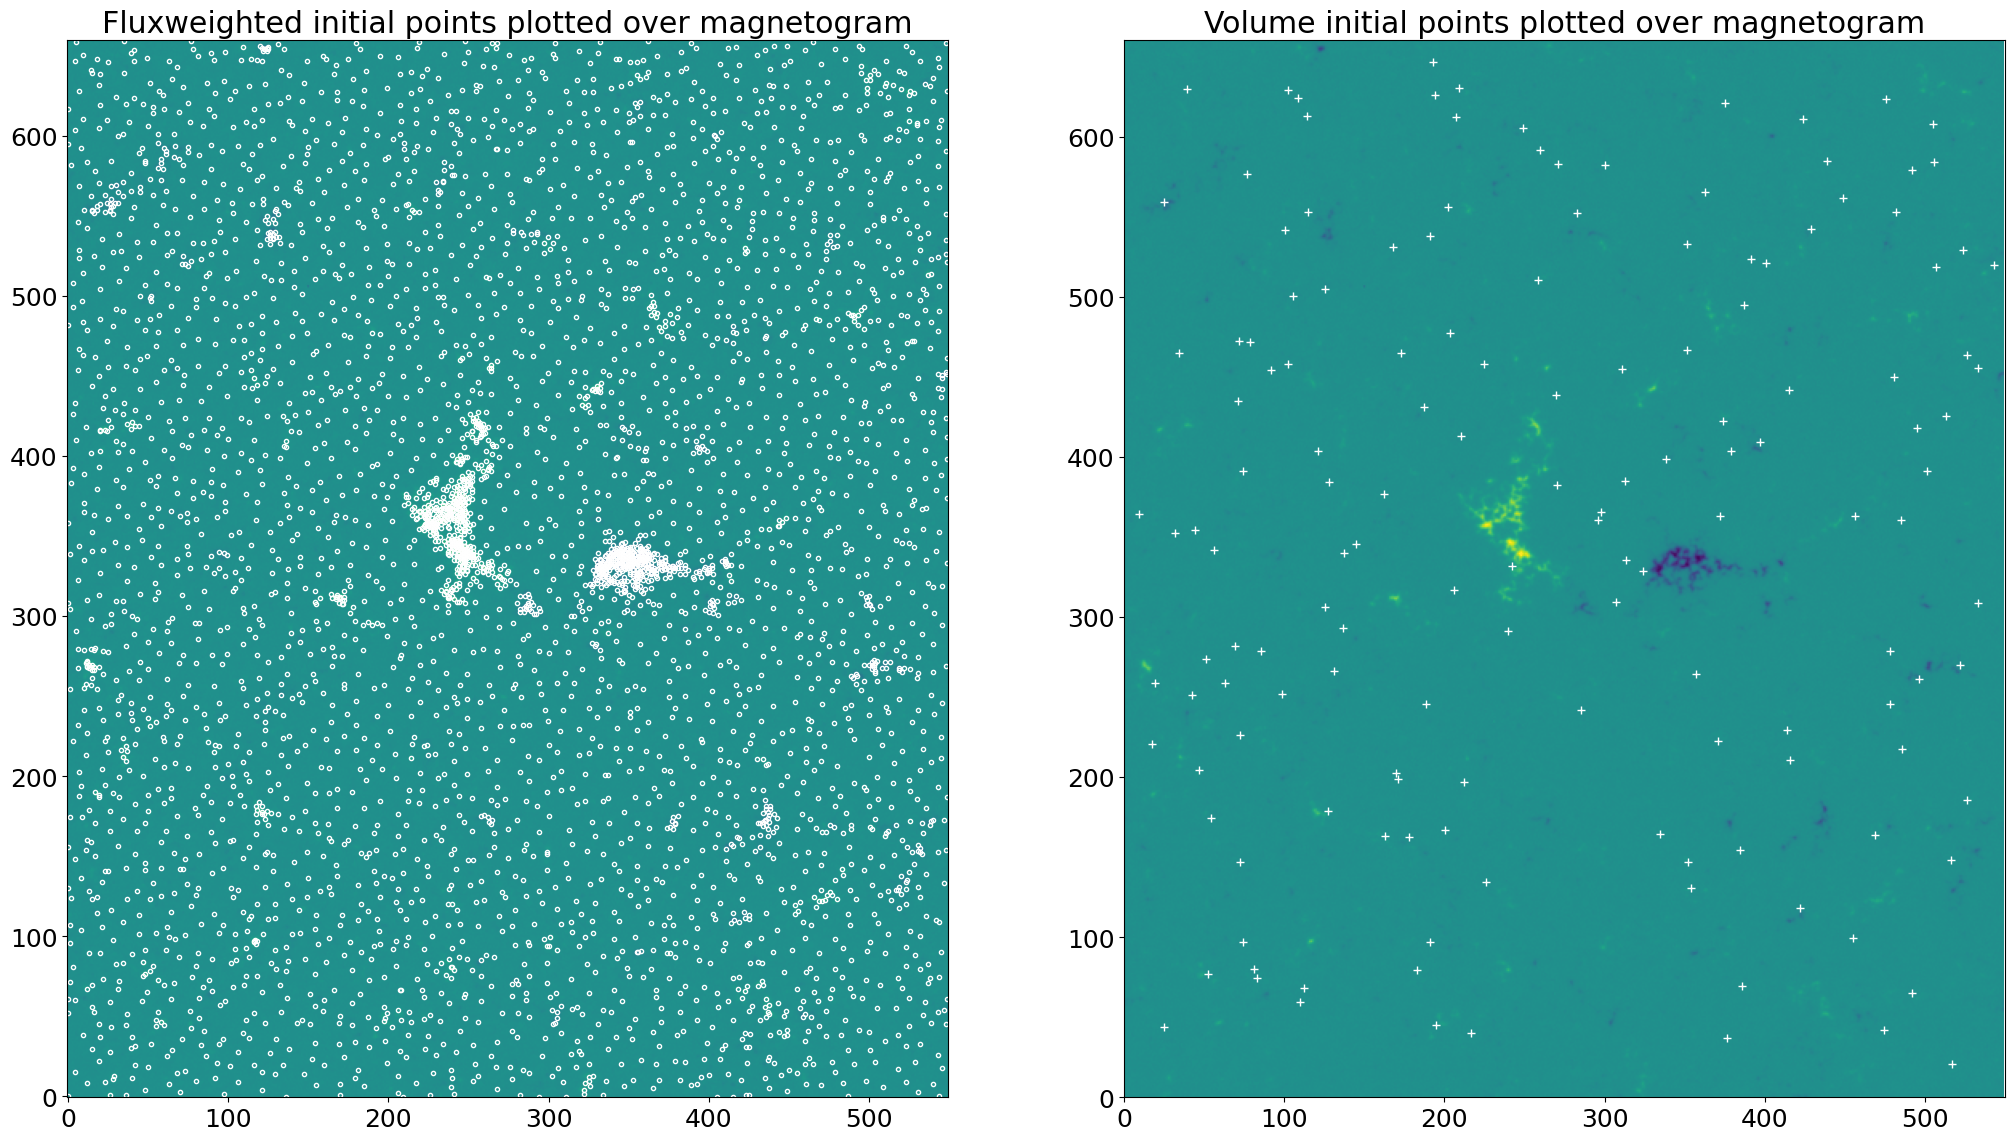

In [11]:
fig = plt.figure(figsize=[25,30])
extent = np.array([bounds0[0,0],bounds0[1,0],bounds0[0,1],bounds0[1,1]])/1.0e8

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax1.plot(fluxw_initial_pt_pix[:,1],fluxw_initial_pt_pix[:,0],'.',color='white', markerfacecolor='none')
ax1.set(title='Fluxweighted initial points plotted over magnetogram')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax2.plot(volume_initial_pt_pix[:,1],volume_initial_pt_pix[:,0],'+',color='white')
ax2.set(title='Volume initial points plotted over magnetogram')
plt.xlim(0,mag.shape[1])
plt.ylim(0,mag.shape[0])

In [12]:
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [13]:
# Trace field lines if newtrace is true:
if(newtrace):
    fieldlines = forcefree_field.tracer(use_points, mag_trace, mag_coords_trace, bounds=tracer_bounds, alpha=alpha, rtol=1.0e-5,atol=0.001*dvox[0], boundrad=magnetogram.center.rsun.to(u.cm).value)
    filehandler = open(loop_savefile,"wb")
    pickle.dump(fieldlines,filehandler)
    filehandler.close()
# Otherwise reload from the previously specified file:
if(newtrace==0):
    file = open(loop_savefile,'rb')
    fieldlines = pickle.load(file)
    file.close()

In [14]:
# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
[fieldlines_resamp,lengths] = resample_loops(fieldlines[0],tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
# Filter out loops whose footpoints fall too close together:
[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, lmin=min_length, zmin = min_height, rcurv=rsun_cm)
nloops = len(fieldlines_filter)
print(nloops0,nloops)

4650 1545


In [15]:
# Create core voxel cube identifying every voxel with a loop:
[loopids, loopid_info, voxel_loop_lengths] = label_loop_regions(fieldlines_filter, lengths_filter, vox_grid)

Total number of loop points =  317957
Memory usage:  657220  kb
Computing Voronoi cells:
Done computing Voronoi cells, elapsed time= 30.45048213005066
Memory usage: 5327256 (kb)
Memory usage:  5327256  kb
Number of Chunks:  90
Checked chunk 3 , elapsed time: 4.537859201431274 s, Memory usage: 5327256 kb
Checked chunk 7 , elapsed time: 12.181935787200928 s, Memory usage: 5327256 kb
Checked chunk 11 , elapsed time: 17.795941829681396 s, Memory usage: 5327256 kb
Checked chunk 15 , elapsed time: 23.638498306274414 s, Memory usage: 5327256 kb
Checked chunk 19 , elapsed time: 29.048363208770752 s, Memory usage: 5327256 kb
Checked chunk 23 , elapsed time: 35.21413016319275 s, Memory usage: 5327256 kb
Checked chunk 27 , elapsed time: 43.77465343475342 s, Memory usage: 5327256 kb
Checked chunk 31 , elapsed time: 55.70746612548828 s, Memory usage: 5327256 kb
Checked chunk 35 , elapsed time: 59.138540267944336 s, Memory usage: 5327256 kb
Checked chunk 39 , elapsed time: 63.287747859954834 s, Memo

In [16]:
# Produce a mask cube which is used to zero out points in the 
# cube that are beneath the solar surface:
limb_mask = get_limb(vox_grid,rsun_cm)

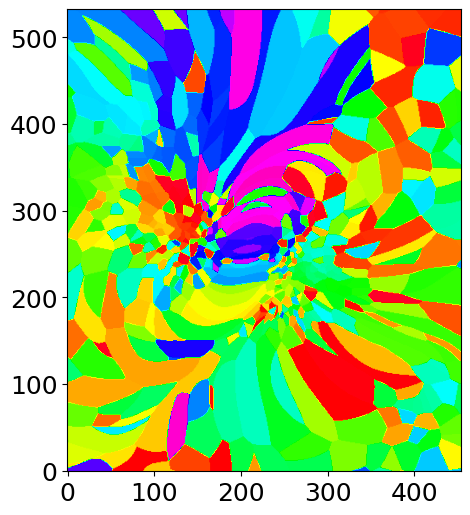

In [17]:
# This is a slice of the voxel label cube at a particular height with the limb mask applied,
# showing each loop as a different color
indx = 75
plt.imshow((limb_mask[:,:,indx]*loopids[:,:,indx] % 200).T, origin='lower',cmap=plt.get_cmap('gist_rainbow'))

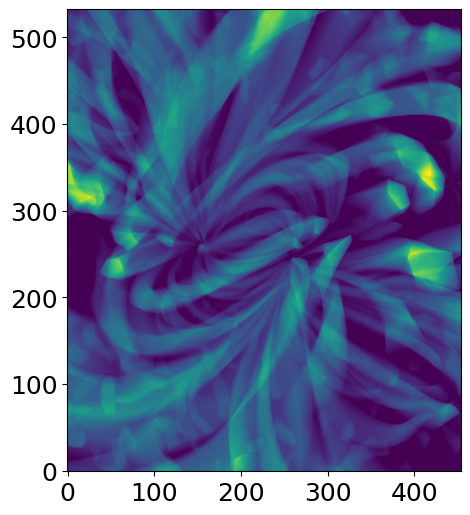

In [18]:
# This is a sum through the cube with every 5th loop illuminated:
plt.imshow(np.sum(limb_mask*(loopids % 5 == 0),axis=2).T)

In [19]:
import reconstruct_2comp_3Dloops
importlib.reload(reconstruct_2comp_3Dloops)
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission


# Compute the forward matrix from the field-aligned regions to the data:
[amat,modelinputs] = compute_fwdmat(aiadat_path, None, loopids, loopid_info,
                                    vox_grid, cropr1, magnetogram, voxel_loop_lengths, curvature=False, 
                                    vox_mask=limb_mask, xpo1 = chan1_xpo, xpo2 = chan1_xpo, temp1=scaltemp1, 
                                    psf_size_px=0.4, zmin=np.min(mag_coords[2]), temp2=scaltemp2, asym=True)

../example_data/aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits None 700000.0 700000.0 2.0 2.0 None None 6000.0 500.0 None -1747156785.2866218 3 None 0.4 True False None None None None None None None None None 0.3333333333333333 1.0
Memory usage: 5327256 (kb)
179795 49
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (-9.47972897e+09, -1.1259092e+10, 6.78871018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (9.54627103e+09, -1.1259092e+10, 6.78871018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon,

In [20]:
# Error estimates for the reconstruction:
chan1_err = estimate_aia_error(modelinputs['map'], channel = 'AIA'+modelinputs['map'].meta['wave_str'])
# Reconstruct using the forward matrix:
solution = reconstruct(amat, modelinputs, reg_fac=0.15, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5)

4.4061320906209795 36.41208590564402 1400.0
7110.176 7110.176
Guess0 min: 145.25157 Guess0 max: 22983.557
Guess0 min: 4.978467 Guess0 max: 10.042534
Overall regularization factor: 7.109101147787516e-05
61.575443267822266 3838877.6122629503 8.869283 8.869283
0.00075423875 0.051509216
step scaling: 1.0 21.72451 1.386293925072172
[1.3241595e+02 1.1956957e+02 9.5003464e+01 6.3452020e+02 2.4643048e+06
 3.4393477e+09 7.8132355e+12]
2.95 s i = 0 chi2 = 94.99 step size = 0.15 reg. param. = 0.02 chi2 change = 37.40821 reg. change = 0.00429
Setup:  0.008851289749145508 Solver:  2.884788751602173 Stepper:  0.05943107604980469
New combined FOM: 95.00346165732108 Old combined FOM: 132.4159587536368 Change: 37.41249709631572
47.44749069213867 2796026.6930629713 7.8560157 12.127959
0.00075423875 0.051509216
step scaling: 1.0 7.975885 1.386293925072172
[ 95.00346   86.06646   70.72206   53.357624  42.000946  51.30709
 109.2766  ]
5.44 s i = 1 chi2 = 41.99 step size = 0.5 reg. param. = 0.01 chi2 change

In [21]:
# The product of the field-aligned region solution vector and the forward matrix is the reconstruction's estimate
# of the AIA image. amat and the solution use a scaled version of the matrix which greatly improves convergence of 
# Krylov methods, hence the loop_weights factors. For a single forward matrix rescaling by the loop weights below
# isn't necessary, but for multiple forward matrices (e.g., multiple perspectives) it is:
soln = copy.deepcopy(solution[0])/modelinputs['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(modelinputs['loop_weights']*soln)).reshape(modelinputs['map'].data.shape)

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

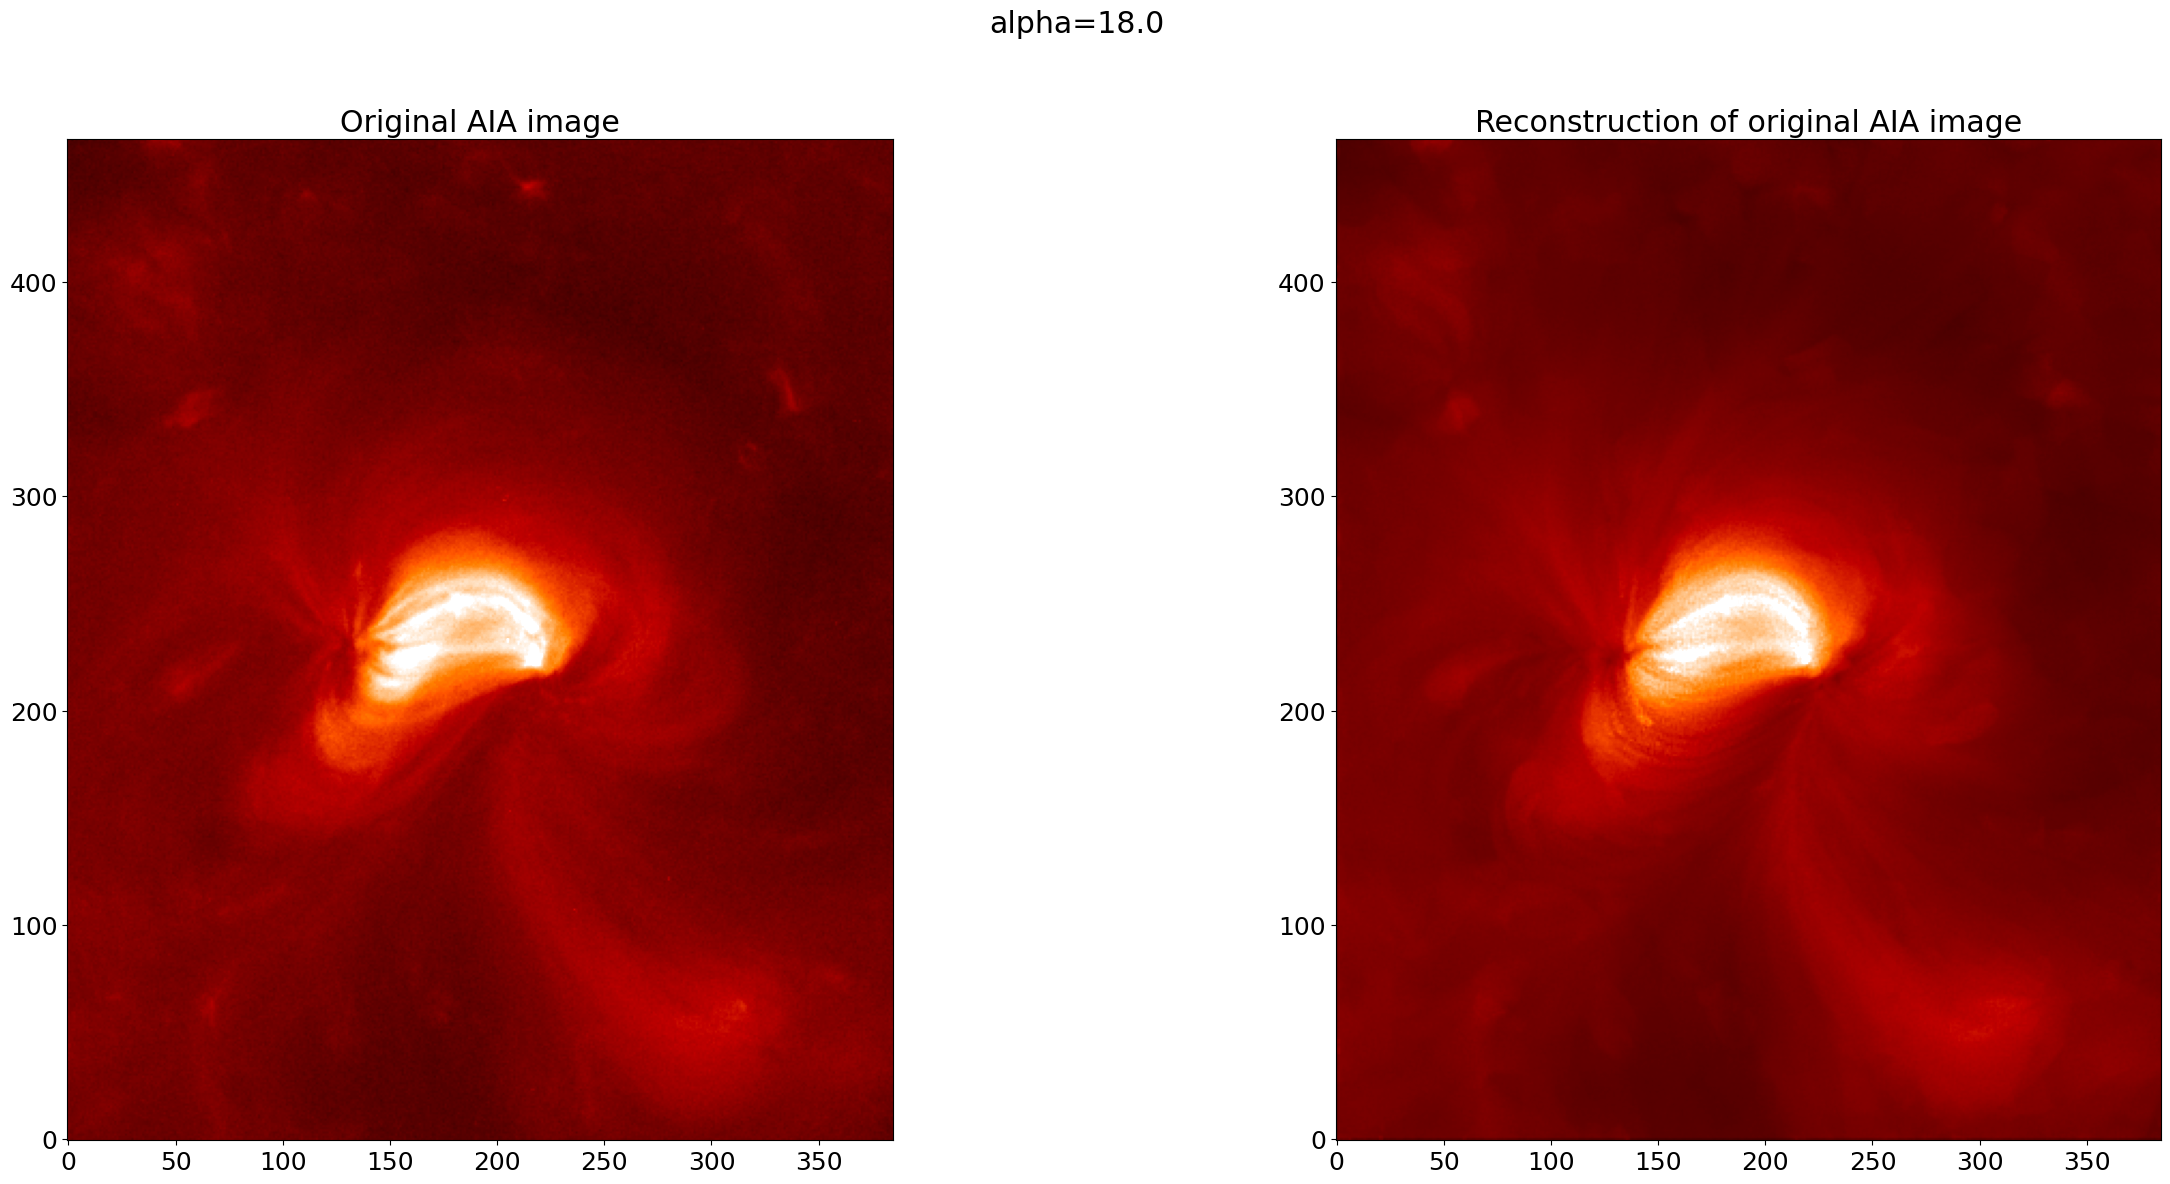

In [22]:
pltmax = 1000

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[30,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(np.abs(modelinputs['map'].data)**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [23]:
# Expand the solution into a 3D emission cube: 
em3d = get_3d_emission(solution[0], modelinputs, vox_grid, loopids, voxel_loop_lengths, loopid_info, zmin=np.min(mag_coords[2]))

Memory usage: 2192772 (kb)
0 283 -1747156785.2866218 11928000000.0


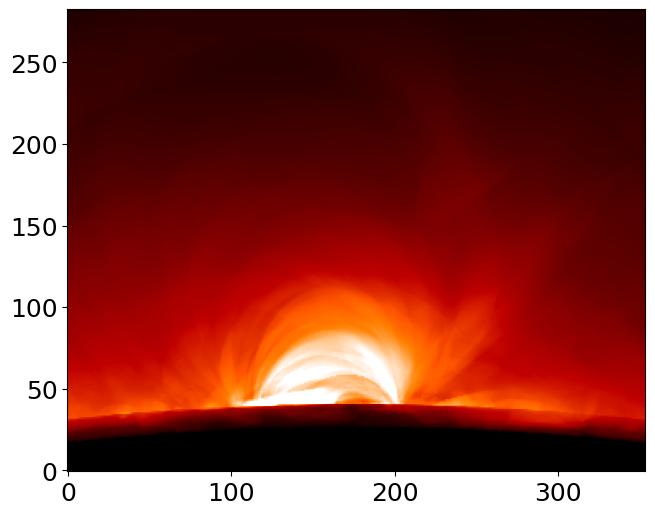

In [24]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from the pole):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=1).T**gfac,vmin=0,vmax=3.0e-5**gfac,cmap=plt.get_cmap('gist_heat'))

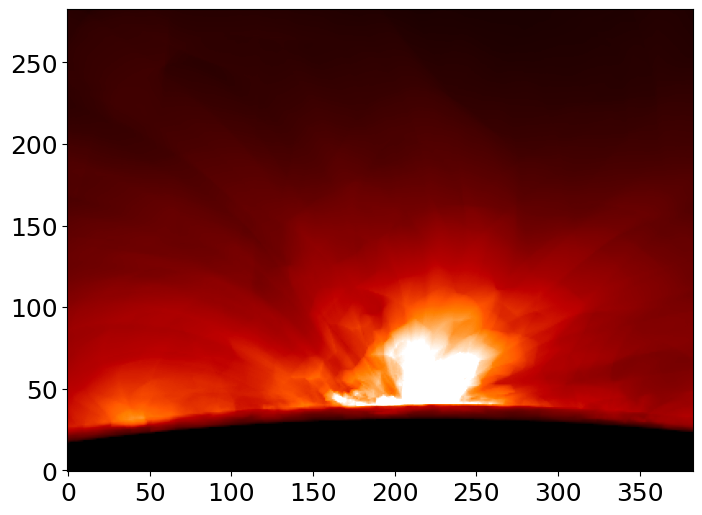

In [25]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from ecliptic latitude):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=0).T**gfac,vmin=0,vmax=3.0e-5**gfac,cmap=plt.get_cmap('gist_heat'))

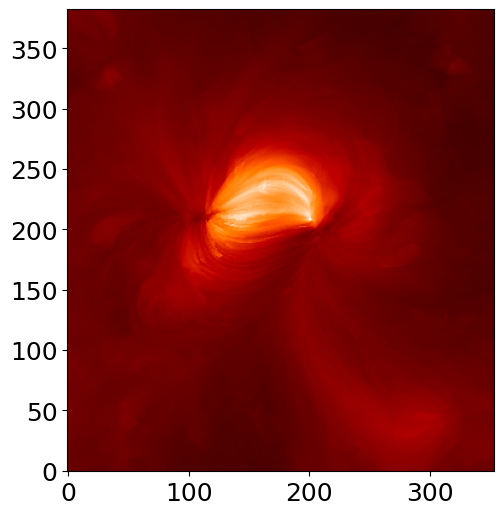

In [26]:
# Plot the x-y projection through the cube (e.g., as viewed from directly overhead):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=2).T**gfac,vmin=0,vmax=3.0e-5**gfac,cmap=plt.get_cmap('gist_heat'))

In [27]:
# Save the reconstructed 3D emission cube:
em3d_out = em3d[50:-50,50:-100,:]*limb_mask[50:-50,50:-100,:]
em3d_norm = np.max(em3d_out)
print(em3d_norm*dvox[2])
mask_out = limb_mask[50:-50,50:-100,:]
em3d_out = (254*(em3d_out/np.max(em3d_out))**0.5).astype(np.uint8)
em3d_out[mask_out==False] = 255
np.save(em3d_savefile, em3d_out, allow_pickle=False) 

236.6285534662893


In [58]:
output_mask = np.zeros(em3d.shape,dtype=bool)
output_mask[50:-50,50:-50,:] = True

phi = 90

from project2frame import project

In [82]:
vox_lct

In [85]:
lon = modelinputs['map'].center.observer.lon
lat = modelinputs['map'].center.observer.lat
rad = modelinputs['map'].center.observer.radius

from local_cartesian_transform import transform, vox2pix, wrld2pix

cenpx0 = vox2pix(0.5*loopid_info['nvox'], loopid_info['voxmin'], loopid_info['dvox'], 
				 magnetogram, modelinputs['map'], obswcs=modelinputs['map'].wcs, 
				 voxcenter=magnetogram.center, vox_lct=vox_lct)

print(cenpx0)

<SkyCoord (HeliocentricEarthEcliptic: obstime=2018-02-03T14:09:23.300): (x, y, z) in cm
    (7.37193795e+10, 1.55562284e+09, -3.73153871e+09)>
[226.59700185 197.37917614]


In [95]:
# Plot a 3D rotation through the cube:
for i in range(00,361):
#for i in range(270,271):
	phi=i
	projection,psfmat = project(output_mask*em3d*limb_mask*dvox[2], loopid_info, initialpoint_dict, lat=lat, lon=lon+phi*u.deg, rad=rad, 
				   tim = modelinputs['map'].date, nx=4096, ny=4096, dx=0.6, dy=0.6, rota=0.0,
				   xrefpx=2048, yrefpx=2048, xrefcrd=0.0, yrefcrd=0.0, psfmat=psfmat)
	
	#il,ih,jl,jh = [1550,1960,1900,2255]

	if(i == 0): cenpx0 = vox2pix([0.5,0.5,0.5]*loopid_info['nvox'], loopid_info['voxmin'], loopid_info['dvox'], 
								 magnetogram, projection, obswcs=projection.wcs,
								 voxcenter=magnetogram.center, vox_lct=vox_lct)

	cenpx = vox2pix([0.5,0.5,0.5]*loopid_info['nvox'], loopid_info['voxmin'], loopid_info['dvox'], 
								 magnetogram, projection, obswcs=projection.wcs,
								 voxcenter=magnetogram.center, vox_lct=vox_lct)

	print(cenpx0)
	print(cenpx)
	
	jl,jh,il,ih = np.round(np.array(cropr1.value)/0.6).astype(np.int32)+2048 # [1550,1960,1900,2255]
	print(il,ih,jl,jh)
	yoff = cenpx0[0]-cenpx[0] #np.round(90*np.sin(phi*np.pi/180.0)**2/0.6).astype(np.int32)
	xoff = cenpx0[1]-cenpx[1] #+ np.sin(phi*np.pi/180.0)*(0.2*(jh-jl)+0.0*rsun_cm/asec_cm/0.6)
	#yoff = np.round(90*np.sin(phi*np.pi/180.0)**2/0.6).astype(np.int32)
	#xoff = np.round(np.sin(phi*np.pi/180.0)*(0.2*(jh-jl)+rsun_cm/asec_cm/0.6)).astype(np.int32)
	jl -= np.round(xoff).astype(np.int32)
	jh -= np.round(xoff).astype(np.int32)
	il -= np.round(yoff).astype(np.int32)
	ih -= np.round(yoff).astype(np.int32)
	
	extent = (np.array([jl,jh,il,ih])-2048)*0.6
	fig = plt.figure(figsize=[11,11]) #fig,axes = plt.subplots(nrows=1,ncols=1,figsize=[12,12])
	plt.imshow(projection.data[il:ih,jl:jh]**0.5,vmin=0,vmax=1400**0.5,extent=extent)
	plt.title(r' AIA 211 reconstruction at '+date+', rotated '+str(360-phi)+'$^\circ$')
	plt.xlabel('Rotated Helioprojective Longitude (Solar-X, arcseconds)')
	plt.ylabel('Helioprojective Latitude (Solar-Y, arcseconds)')
	fig.tight_layout()
	plt.savefig(os.path.join(rotation_directory,'AIA211_rot'+str(360-phi).zfill(3)+'deg.png'))
	#plt.savefig('../plot/CROBAR3figs/rotation/AIA211_rot'+str(360-phi).zfill(3)+'deg.png')#,bbox_inches='tight')
	print('Finished '+str(360-phi)+' degrees')
	plt.close()

<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (-9.50072897e+09, -1.1280092e+10, 6.78661018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (9.52527103e+09, -1.1280092e+10, 6.78661018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (-9.50072897e+09, 1.1063908e+10, 6.78661018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=6957

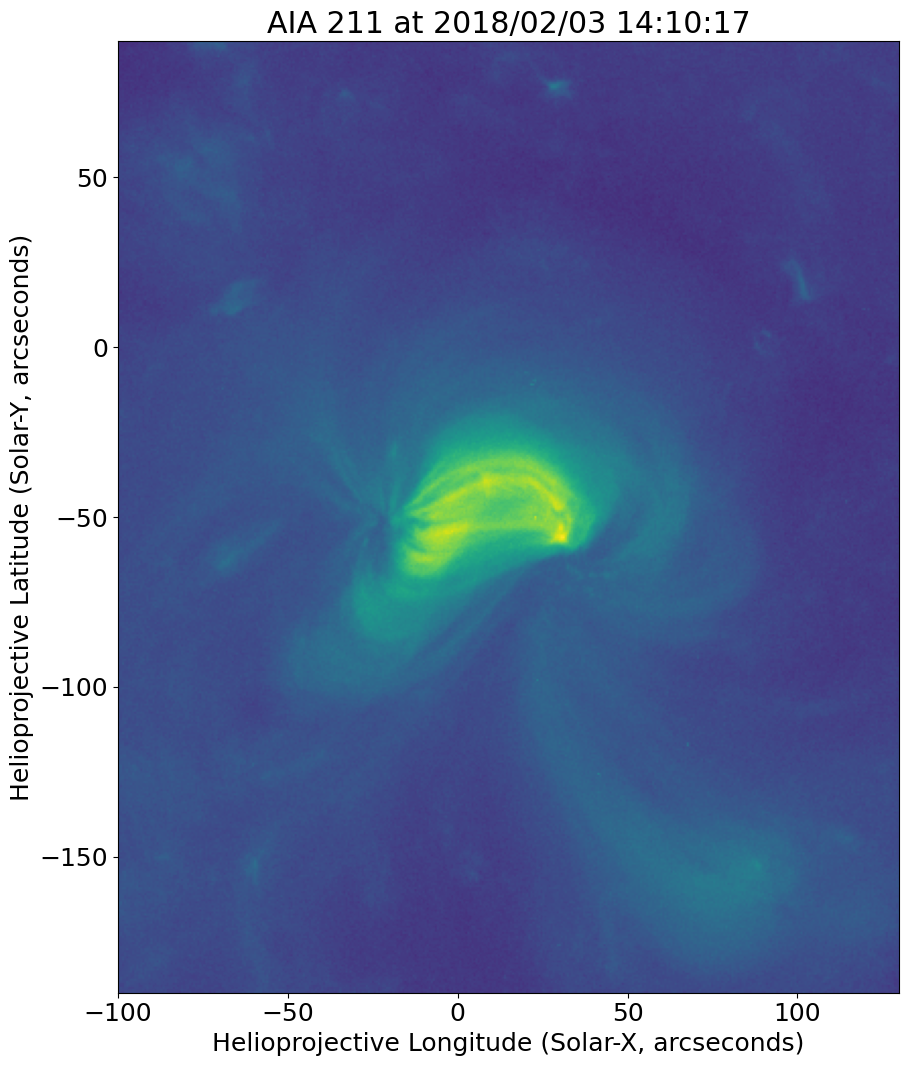

In [41]:
fig = plt.figure(figsize=[11,11]) #fig,axes = plt.subplots(nrows=1,ncols=1,figsize=[12,12])
plt.imshow(modelinputs['map'].data**0.5, vmin=0,vmax=1400**0.5, extent = cropr1.value)
plt.title(r'AIA 211 at '+date)
plt.xlabel('Helioprojective Longitude (Solar-X, arcseconds)')
plt.ylabel('Helioprojective Latitude (Solar-Y, arcseconds)')
fig.tight_layout()
plt.savefig(os.path.join(rotation_directory,'AIA211_orig.png'))

In [49]:
0.6*cropr1.value

array([ -60.,   78., -114.,   54.])